In [41]:
import os, collections

from Bio import pairwise2
from Bio.Seq import Seq
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from data import AllBooks, Book
from utils import most_frequent

#import bible_datasets

from align_config import dss_version, sp_version
from align_functions import make_alignments, collect_matching_words

from tf.app import use

MT = use('etcbc/bhsa')
Fmt, Tmt, Lmt = MT.api.F, MT.api.T, MT.api.L

#SP = use('dt-ucph/sp', version=sp_version)
#Fsp, Tsp, Lsp = SP.api.F, SP.api.T, SP.api.L

DSS = use('etcbc/dss', version=dss_version)
Fdss, Tdss, Ldss = DSS.api.F, DSS.api.T, DSS.api.L


**Locating corpus resources ...**

Name,# of nodes,# slots / node,% coverage
book,39,10938.21,100
chapter,929,459.19,100
lex,9230,46.22,100
verse,23213,18.38,100
half_verse,45179,9.44,100
sentence,63717,6.70,100
sentence_atom,64514,6.61,100
clause,88131,4.84,100
clause_atom,90704,4.70,100
phrase,253203,1.68,100


**Locating corpus resources ...**

Name,# of nodes,# slots / node,% coverage
scroll,1001,1428.81,100
lex,10450,129.14,94
fragment,11182,127.91,100
line,52895,27.04,100
clause,125,12.85,0
cluster,101099,6.68,47
phrase,315,5.10,0
word,500995,2.81,99
sign,1430241,1.00,100


In [42]:
DATA_FOLDER = '../data'
MATRES_FILES = ['nouns_adjectives.csv', 'ptca_qal.csv', 'ptcp_qal.csv', 'niph_hiph_pe_yod.csv', 'infa_qal.csv',
               'infc_qal_triliteral.csv', 'infc_qal_lamed_he.csv', 'hiphil_triliteral_with_hireq.csv']

In [43]:
PENTATEUCH_BOOKS = ['Genesis', 'Exodus', 'Leviticus', 'Numbers', 'Deuteronomy']
ALL_BOOK_NAMES = [Tmt.sectionFromNode(bo)[0] for bo in Fmt.otype.s('book')]

In [44]:
QSP_SCROLLS = {'1Qisaa', '1QisaaI', '1QisaaII', '2Q3', '4Q13', '4Q20', '2Q7', '4Q27', '1Q4', '2Q12', '4Q37', '4Q38', '4Q38a', '4Q40', '4Q53',
               '4Q57', '2Q13', '4Q78', '4Q80', '4Q82', '4Q128', '4Q129', '4Q134', '4Q135', '4Q136',
                '4Q137', '4Q138', '4Q139', '4Q140', '4Q141', '4Q142', '4Q143', '4Q144', '4Q158', '4Q364',
                '4Q365', '4Q96', '4Q111', '4Q109', '11Q5', '11Q6', '11Q7', '11Q8'}

# Prepare MT and SP texts

Produce dictionary mt_sp_matches which has mt words nodes as keys and matching word numbers from SP as values.

In [45]:
# prepare mt and sp books
MANUSCRIPTS = ['MT', 'SP']
all_books = AllBooks()
for book_name in ALL_BOOK_NAMES:
    book = Book('MT', book_name, Fmt, Tmt, Lmt)
    all_books.data[('MT', book_name)] = book
    
    #if book_name in PENTATEUCH_BOOKS:
    #    book = Book('SP', book_name, Fsp, Tsp, Lsp)
    #    all_books.data[('SP', book_name)] = book

# Match words

In [46]:
all_data = []

for file_name in MATRES_FILES:
    file_path = DATA_FOLDER + '/' + file_name
    feature_name = file_name.split('.')[0]
    data_one_feature = pd.read_csv(file_path, sep='\t')
    data_one_feature['feature'] = feature_name
    all_data.append(data_one_feature)
    
dat = pd.concat(all_data)
dat.shape

(63287, 39)

In [49]:
dat.dtypes

tf_id                   int64
scroll                 object
book                   object
chapter                 int64
verse                   int64
lex                    object
g_cons                 object
stem                   object
pattern                object
pattern_g_cons         object
vs                     object
vt                     object
nu                     object
gn                     object
ps                     object
sp                     object
prs                    object
nme                    object
hloc                   object
prefix                 object
rec_signs              object
cor_signs              object
heb_g_cons             object
feature                object
other_vowel_ending     object
line                   object
column                 object
has_prs                 int64
has_prefix              int64
has_hloc                int64
has_nme                 int64
rec_signs_stem         object
cor_signs_stem         object
type      

In [50]:
# Remove hiphil without hireq

dat = dat[(dat.feature != 'hiphil_triliteral_with_hireq') | (dat.feature == 'hiphil_triliteral_with_hireq') & (dat.has_hireq == '1')] # & dat.has_hireq == 1)]

In [51]:
dat['book2'] = pd.Series(dat.book.str.replace('1_', '').str.replace('2_', ''))

In [52]:
#dat = pd.read_csv(MATRES_FILE, sep='\t')

# dat_dss means non-MT, SP is included
dat_dss = dat[~dat.scroll.isin(['MT'])]
scroll_book_combinations = list(set(zip(dat_dss.scroll, dat_dss.book)))
dat_dss.shape

(19271, 40)

In [53]:
for manuscript, book_name in scroll_book_combinations:
    if manuscript == 'MT':
        continue
    #elif manuscript == 'SP':
    #    book = Book(manuscript, book_name, Fsp, Tsp, Lsp)
    #    all_books.data[(manuscript, book_name)] = book
    else:
        book = Book(manuscript, book_name, Fdss, Tdss, Ldss)
        all_books.data[(manuscript, book_name)] = book

In [54]:
def make_matching_word_dict(book_name, all_books):

    all_match_dicts = {}

    matching_book = book_name
    matching_manuscripts = [scr for scr, bo in all_books.data.keys() if bo == matching_book]

    for man1 in matching_manuscripts:
        for man2 in matching_manuscripts:
            if man1 != man2:
            
                man1_verse_texts = all_books.data[(man1, matching_book)].verse_text_dict
                man2_verse_texts = all_books.data[(man2, matching_book)].verse_text_dict

                alignments_dict = make_alignments(man1_verse_texts, man2_verse_texts)
    
                man1_word2char = all_books.data[(man1, matching_book)].word2char
                man2_word2char = all_books.data[(man2, matching_book)].word2char
 
                matching_words_dict = collect_matching_words(alignments_dict, man1_word2char, man2_word2char)

                matches = {}
                for man1_word, man2_list in matching_words_dict.items():
                    man2_word = most_frequent(man2_list)
                    matches[man1_word] = man2_word
                all_match_dicts[((man1, matching_book), (man2, matching_book))] = matches
                
    return all_match_dicts, matching_manuscripts

In [55]:
def read_dataset(file):

    return pd.read_csv(file, sep='\t')

In [56]:
class MaterData:
    def __init__(self, man1, man2, section, lex, mater_val1, mater_val2, tf_id1, tf_id2, g_cons1, g_cons2):
        self.man1 = man1
        self.man2 = man2
        self.section = section
        self.lex = lex
        self.mater_val1 = mater_val1
        self.mater_val2 = mater_val2
        self.tf_id1 = tf_id1
        self.tf_id2 = tf_id2
        self.g_cons1 = g_cons1
        self.g_cons2 = g_cons2

In [57]:
def collect_matching_cases(matching_manuscripts, matching_book, dat):

    all_mater_datasets = {}

    for man in matching_manuscripts:
        mater_data = dat[(dat.book == matching_book) & (dat.scroll == man)]
        all_mater_datasets[(man, matching_book)] = mater_data
        
    return all_mater_datasets

In [58]:
def collect_mater_data(matching_manuscripts, all_match_dicts, all_mater_datasets, matching_book):

    manuscript_mater_match = collections.defaultdict(list)
    manuscripts = set()

    for idx, man in enumerate(matching_manuscripts):
        for idx2, man2 in enumerate(matching_manuscripts):
            if idx < idx2:
            
                matching_ids = all_match_dicts[((man, matching_book), (man2, matching_book))]
                man_data = all_mater_datasets[(man, matching_book)]
                man2_data = all_mater_datasets[(man2, matching_book)]
                for _, row in man_data.iterrows():
                
                    tf_id = row.tf_id
                    lex, typ, has_vl = row.lex, row.type, row.has_vowel_letter
                    g_cons1 = row.g_cons
                    section = (row.book, row.chapter, row.verse)
                    if man == 'SP':
                        tf_id = tf_id - 100000

                    matching_tf_id = matching_ids.get(tf_id, None)
                
                    if not matching_tf_id:
                        continue
                    
                    if man2 == 'SP':
                        matching_tf_id = matching_tf_id + 100000
                
                    man2_row = man2_data[(man2_data.tf_id == matching_tf_id) & (man2_data.lex == lex) & (man2_data.type == typ)]
                    
                    if not man2_row.shape[0]:
                        continue
                    has_vl2 = man2_row.has_vowel_letter.iloc[0]
                    g_cons2 = man2_row.g_cons.iloc[0]
                 
                    mater_data = MaterData(man, man2, section, lex, has_vl, has_vl2, tf_id, matching_tf_id, g_cons1, g_cons2)
                
                    manuscript_mater_match[man].append(mater_data)
                    manuscripts.add(man)
                    manuscripts.add(man2)
                    
    return manuscript_mater_match, manuscripts

In [100]:
def register_similarities_with_mt(manuscripts, mt_ids, manuscript_mater_match):

    mater_value_dict = {0: -1,
                    1: 1}

    mater_match_array = np.zeros((len(manuscripts), len(mt_ids)))

    for dat_object in manuscript_mater_match['MT']:
        
        other_man = dat_object.man2
        mt_tfid = dat_object.tf_id1
        other_man_tfid = dat_object.tf_id2
    
        mt_mater = dat_object.mater_val1
        other_man_mater = dat_object.mater_val2
    
        mt_idx = man2idx['MT']
        other_man_idx = man2idx[other_man]
    
        mt_mater_value = mater_value_dict[mt_mater]
        other_man_mater_value = mater_value_dict[other_man_mater]
    
        mt_tf_id = mt_tf2idx[mt_tfid]
    
        mater_match_array[mt_idx, mt_tf_id] = mt_mater_value
        mater_match_array[other_man_idx, mt_tf_id] = other_man_mater_value
        
    return mater_match_array

In [101]:
def get_parallels(manuscript_mater_match, hif_match_dict):
    for scroll in manuscript_mater_match.keys():
        for dat_object in manuscript_mater_match[scroll]:
            man1 = dat_object.man1
            man2 = dat_object.man2
            
            hif_match_dict[(dat_object.tf_id2, man2)][man1] = dat_object.tf_id1
            hif_match_dict[(dat_object.tf_id1, man1)][man2] = dat_object.tf_id2
        
    return hif_match_dict


In [102]:
def count_parallel_cases(mater_match_array):

    mater_arr = np.zeros((2, mater_match_array.shape[1]))

    for col_idx in range(mater_match_array.shape[1]):
        col = mater_match_array[:, col_idx]
        col_counts = collections.Counter(col)
        with_vowel_count = col_counts.get(1, 0)
        without_vowel_count = col_counts.get(-1, 0)
        mater_arr[0, col_idx] = with_vowel_count
        mater_arr[1, col_idx] = without_vowel_count
        
    return mater_arr

In [103]:
hif_match_dict = collections.defaultdict(lambda: collections.defaultdict(int))

for book in {'Isaiah'}: #ALL_BOOK_NAMES:
    print(book)
    all_match_dicts, matching_manuscripts = make_matching_word_dict(book, all_books)
    all_mater_datasets = collect_matching_cases(matching_manuscripts, book, dat)
    manuscript_mater_match, manuscripts = collect_mater_data(matching_manuscripts, all_match_dicts, all_mater_datasets, book)
    
    hif_match_dict = get_parallels(manuscript_mater_match, hif_match_dict)
    print(len(hif_match_dict))
    

Isaiah
6743


In [104]:
all_scrolls = set(dat_dss.scroll) 
non_qsp_scrolls = all_scrolls.difference(QSP_SCROLLS)
non_qsp_data = dat_dss[dat_dss.scroll.isin(non_qsp_scrolls)]

In [105]:
set(dat_dss.scroll)

{'11Q1',
 '11Q2',
 '11Q4',
 '11Q5',
 '11Q6',
 '11Q7',
 '11Q8',
 '1Q1',
 '1Q10',
 '1Q11',
 '1Q12',
 '1Q13',
 '1Q2',
 '1Q3',
 '1Q4',
 '1Q5',
 '1Q6',
 '1Q7',
 '1Q71',
 '1Q8',
 '1Q9',
 '1Qisaa',
 '2Q11',
 '2Q13',
 '2Q14',
 '2Q15',
 '2Q16',
 '2Q17',
 '2Q2',
 '2Q3',
 '2Q5',
 '2Q6',
 '2Q7',
 '2Q9',
 '34Se1',
 '34Se2',
 '3Q2',
 '3Q3',
 '4Q1',
 '4Q10',
 '4Q100',
 '4Q101',
 '4Q102',
 '4Q103',
 '4Q104',
 '4Q105',
 '4Q106',
 '4Q107',
 '4Q108',
 '4Q109',
 '4Q11',
 '4Q110',
 '4Q111',
 '4Q112',
 '4Q113',
 '4Q114',
 '4Q128',
 '4Q129',
 '4Q13',
 '4Q130',
 '4Q131',
 '4Q133',
 '4Q134',
 '4Q135',
 '4Q136',
 '4Q137',
 '4Q138',
 '4Q139',
 '4Q14',
 '4Q140',
 '4Q141',
 '4Q142',
 '4Q143',
 '4Q145',
 '4Q146',
 '4Q149',
 '4Q15',
 '4Q150',
 '4Q151',
 '4Q152',
 '4Q153',
 '4Q154',
 '4Q155',
 '4Q16',
 '4Q17',
 '4Q18',
 '4Q2',
 '4Q20',
 '4Q21',
 '4Q22',
 '4Q23',
 '4Q24',
 '4Q25',
 '4Q26',
 '4Q26a',
 '4Q26b',
 '4Q26c',
 '4Q27',
 '4Q28',
 '4Q29',
 '4Q3',
 '4Q30',
 '4Q31',
 '4Q32',
 '4Q33',
 '4Q34',
 '4Q35',
 '4Q36',
 '

In [64]:
## Calculate how individual features vary in pairs of manuscripts.

In [106]:
n = 0
isa_dict = collections.defaultdict(lambda: collections.defaultdict(lambda: collections.defaultdict(int)))
id_combinations = set()


for index, row in dat_dss.iterrows():
    tf_id = row.tf_id, 
    scroll = row.scroll, 
    has_vl = row.has_vowel_letter
    book, ch, ve = row.book, row.chapter, row.verse
    g_cons = row.g_cons
    lex = row.lex
    prefix = row.prefix
    feature = row.feature
    typ = row.type
    feature = feature + '_' + typ
    
    if book != 'Isaiah':
        continue

    if (tf_id[0], scroll[0]) in hif_match_dict:

        matching_man_dict = hif_match_dict[(tf_id[0], scroll[0])]
        
        if scroll[0] == '1Qisaa' and 'MT' not in matching_man_dict:
            print(book, ch, ve, lex, g_cons)
        
        for man, corr_id in matching_man_dict.items():

            corr_row = dat[dat.tf_id == corr_id]
            n += 1
        
            mt_full = corr_row.has_vowel_letter.iloc[0]
            corr_scroll = corr_row.scroll.iloc[0]
            corr_vl = corr_row.has_vowel_letter.iloc[0]
            #print(scroll, corr_scroll, has_vl, corr_vl, g_cons, corr_row.g_cons.iloc[0], prefix, book, ch, ve)
            
            if not tuple(sorted([tf_id[0], corr_id])) in id_combinations:
                isa_dict[(scroll[0], man)][feature][(has_vl, corr_vl)] += 1
            id_combinations.add(tuple(sorted([tf_id[0], corr_id])))
            
    elif scroll[0] == '1Qisaa':
        print('NOT IN MATCH_DICT', book, ch, ve, lex)
            
    
print(n)

NOT IN MATCH_DICT Isaiah 1 15 <WN/
NOT IN MATCH_DICT Isaiah 3 24 BCT/
NOT IN MATCH_DICT Isaiah 5 12 P<LH/
NOT IN MATCH_DICT Isaiah 5 12 P<LH/
NOT IN MATCH_DICT Isaiah 5 27 J<P/
NOT IN MATCH_DICT Isaiah 5 28 YWR/
NOT IN MATCH_DICT Isaiah 8 3 NBJ>/
NOT IN MATCH_DICT Isaiah 9 6 MRBH/
NOT IN MATCH_DICT Isaiah 13 22 <WD/
NOT IN MATCH_DICT Isaiah 14 23 QPWZ/
NOT IN MATCH_DICT Isaiah 16 4 MY/
NOT IN MATCH_DICT Isaiah 16 14 KBWD/
NOT IN MATCH_DICT Isaiah 19 13 NFJ>/
NOT IN MATCH_DICT Isaiah 20 4 GWLH/
NOT IN MATCH_DICT Isaiah 21 1 RXWQ/
NOT IN MATCH_DICT Isaiah 21 8 R>H/
NOT IN MATCH_DICT Isaiah 21 16 CLC/
NOT IN MATCH_DICT Isaiah 22 5 QDC/
NOT IN MATCH_DICT Isaiah 23 9 KL/
NOT IN MATCH_DICT Isaiah 23 11 M<WZ/
NOT IN MATCH_DICT Isaiah 27 2 XMR===/
NOT IN MATCH_DICT Isaiah 28 1 G>WN/
NOT IN MATCH_DICT Isaiah 28 12 J<P/
NOT IN MATCH_DICT Isaiah 28 22 MWSRH/
NOT IN MATCH_DICT Isaiah 29 3 MYWDH/
NOT IN MATCH_DICT Isaiah 29 5 ZD/
NOT IN MATCH_DICT Isaiah 29 7 MYWRH/
NOT IN MATCH_DICT Isaiah 29 16 X

In [66]:
hif_match_dict

defaultdict(<function __main__.<lambda>()>,
            {(2025373,
              '4Q59'): defaultdict(int, {'MT': 212556, '1Qisaa': 1895381}),
             (212556,
              'MT'): defaultdict(int, {'4Q59': 2025373, '1Qisaa': 1895381}),
             (2025384,
              '4Q59'): defaultdict(int,
                         {'MT': 212566, '1Qisaa': 1895390, '4Q60': 2026895}),
             (212566,
              'MT'): defaultdict(int,
                         {'4Q59': 2025384,
                          '1Qisaa': 1895390,
                          '4Q60': 2026895}),
             (2025403,
              '4Q59'): defaultdict(int, {'MT': 212583, '1Qisaa': 1895405}),
             (212583,
              'MT'): defaultdict(int, {'4Q59': 2025403, '1Qisaa': 1895405}),
             (2025412,
              '4Q59'): defaultdict(int, {'MT': 212592, '1Qisaa': 1895414}),
             (212592,
              'MT'): defaultdict(int, {'4Q59': 2025412, '1Qisaa': 1895414}),
             (2025491,
     

In [107]:
len(hif_match_dict)

6743

In [18]:
vowel_letter_pairs = []
feature_counts = collections.defaultdict(int)

for feature, feat_dict in isa_dict[('1Qisaa', 'MT')].items():
    for pair, count in feat_dict.items():
        vowel_letter_pairs += [pair] * count
        feature_counts[feature] += count
    
len(vowel_letter_pairs)    

NameError: name 'isa_dict' is not defined

In [20]:
pd.value_counts(vowel_letter_pairs)

C:\Users\geitb\AppData\Local\Temp\ipykernel_17988\3737605393.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(vowel_letter_pairs)
C:\Users\geitb\AppData\Local\Temp\ipykernel_17988\3737605393.py:1: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  pd.value_counts(vowel_letter_pairs)


Series([], Name: count, dtype: int64)

In [21]:
feature_counts

defaultdict(int, {})

In [22]:
import random
import pprint

In [23]:
def get_feature_counts_and_vowel_pairs(isa_dict, manuscripts):
    vowel_letter_pairs = []
    feature_counts = collections.defaultdict(int)

    for feature, feat_dict in isa_dict[manuscripts].items():
        for pair, count in feat_dict.items():
            vowel_letter_pairs += [pair] * count
            feature_counts[feature] += count
    return feature_counts, vowel_letter_pairs

def get_spelling_difference_counts(feature_spelling_counts):
    man1_pluses = feature_spelling_counts.get((1, 0), 0) + feature_spelling_counts.get((1, 1), 0)
    man2_pluses = feature_spelling_counts.get((0, 1), 0) + feature_spelling_counts.get((1, 1), 0)
    return man1_pluses, man2_pluses


def sample_spelling(feature_spellings, feature_count, n_samples):
    man1_counts = []
    man2_counts = []
    for i in range(n_samples):
        pairs_sample = random.choices(feature_spellings, k=feature_count)
        man1_fuller = np.sum(pairs_sample.count((1, 0))) + np.sum(pairs_sample.count((1, 1)))
        man2_fuller = np.sum(pairs_sample.count((0, 1)))  + np.sum(pairs_sample.count((1, 1)))
        man1_counts.append(man1_fuller)
        man2_counts.append(man2_fuller)
    return man1_counts, man2_counts
    
    
def calculate_sample_mean(counts):
   
    return np.mean(counts)

def make_distribution_df(counts):

    man1_val_counts = pd.DataFrame(pd.value_counts(counts))
    man1_val_counts['value'] = man1_val_counts.index
    man1_val_counts = man1_val_counts.sort_values(by='value')
    return man1_val_counts

def calculate_feature_man_prob(counts_df, feature_man_mean):
    
    #print(counts_df)
    man_cutoff = counts_df[counts_df.value <= feature_man_mean]
    #print(man_cutoff)
    cutoff_count = man_cutoff['count'].sum()
    total_count = counts_df['count'].sum()
    prob = cutoff_count / total_count
    return prob


In [24]:
import scipy.stats as st
import seaborn as sns

def calculate_conf_interval(data):
    data = np.array(data)
    mean = data.mean()
    Z = 1.96

    std = np.std(data)

    print('MEAN STD', mean, std)
    left_limit = mean - (Z * (std / np.sqrt(n)))
    right_limit = mean + (Z * (std / np.sqrt(n)))
    print('LIMITS', left_limit, right_limit)
    return left_limit, right_limit

In [25]:
def run_features_pipeline(isa_dict, manuscripts, feature_counts, vowel_letter_pairs, n_samples):
    
    feature_probs = {}
    
    spelling_counts_all_features = isa_dict[manuscripts]
    
    for feature, feature_count in feature_counts.items():
        
        man1_pluses, man2_pluses = get_spelling_difference_counts(spelling_counts_all_features[feature])
        man1_counts, man2_counts = sample_spelling(vowel_letter_pairs, feature_count, n_samples)

        man1_mean = np.mean(man1_counts)
        man2_mean = np.mean(man2_counts)
        
        #print('mean1:', man1_mean)
        #print('mean2:', man2_mean)
        #print('MAN1 std:', np.std(man1_counts))
        #print('MAN2 std:', np.std(man2_counts))
        #print('MAN1 ci:', calculate_conf_interval(man1_counts))
        #print('MAN2 ci:', calculate_conf_interval(man2_counts))
        
        man1_mean_norm = man1_mean / feature_count
        man2_mean_norm = man2_mean / feature_count
        man1_pluses_norm = man1_pluses / feature_count
        man2_pluses_norm = man2_pluses / feature_count
        #ci1 = calculate_conf_interval(man1_counts)
        #ci2 = calculate_conf_interval(man2_counts)
        
        man1_counts_norm = [count / feature_count for count in man1_counts]
        man2_counts_norm = [count / feature_count for count in man2_counts]

        quantiles1 = np.quantile(man1_counts_norm, [0.025, 0.975])
        quantiles2 = np.quantile(man2_counts_norm, [0.025, 0.975])
        
        feature_probs[feature] = [man1_mean, man2_mean, man1_pluses, man2_pluses, 
                                  man1_mean_norm, man2_mean_norm, man1_pluses_norm,
                                  man2_pluses_norm, quantiles1, quantiles2]
        #print()
        
    return feature_probs
        

In [26]:
feature_counts

defaultdict(int, {})

In [27]:
n_samples = 10000
#manuscripts = ('4Q57', 'MT')

for manuscripts in isa_dict.keys():
    print(manuscripts)
    feature_counts, vowel_letter_pairs = get_feature_counts_and_vowel_pairs(isa_dict, manuscripts)

    probabilities = run_features_pipeline(isa_dict, manuscripts, feature_counts, vowel_letter_pairs, n_samples)
    #pprint.pprint(probabilities)
    print()
    
    #break

NameError: name 'isa_dict' is not defined

In [118]:
probabilities

{'infc_qal_triliteral_last': [np.float64(0.0),
  np.float64(1.0),
  0,
  1,
  np.float64(0.0),
  np.float64(1.0),
  0.0,
  1.0,
  array([0., 0.]),
  array([1., 1.])]}

In [77]:
sns.distplot(probabilities['nouns_adjectives_first'][-1], hist=False)

KeyError: 'nouns_adjectives_first'

In [78]:
calculate_conf_interval(probabilities['nouns_adjectives'][-1])

KeyError: 'nouns_adjectives'

In [79]:
data = np.array(probabilities['nouns_adjectives'][-1])

# 1. X - mean of population
mean = data.mean()
print(mean)

# 2. Z-score
Z = 1.96

# 3. standard deviation of the entire population
std = data.std()
print(std)

#left limit
left_limit = mean - (Z * (std / np.sqrt(n)))
right_limit = mean + (Z * (std / np.sqrt(n)))
print(left_limit, right_limit)

KeyError: 'nouns_adjectives'

In [33]:
import numpy as np
import scipy.stats as st

#define sample data
np.random.seed(0)
data = probabilities['nouns_adjectives'][-1] #np.random.randint(10, 30, 50)

#create 95% confidence interval for population mean weight
st.norm.interval(alpha=0.95, loc=np.mean(data), scale=st.sem(data))

KeyError: 'nouns_adjectives'

In [34]:
sns.distplot(probabilities['nouns_adjectives'][-1], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

KeyError: 'nouns_adjectives'

In [35]:
def get_feature_counts_per_manuscript(isa_dict, manuscripts):
    vowel_letter_pairs = []
    feature_counts = collections.defaultdict(int)

    man1_values = []
    man2_values = []
    for feature, feat_dict in isa_dict[manuscripts].items():
        
        for pair, count in feat_dict.items():
            vowel_letter_pairs += [pair] * count
            feature_counts[feature] += count
    return feature_counts, vowel_letter_pairs

## Calculate average fullness of features of the book of Isaiah

In [119]:
isa_dict

defaultdict(<function __main__.<lambda>()>,
            {('1Qisaa',
              'MT'): defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {'nouns_adjectives_last': defaultdict(int,
                                      {(1, np.int64(1)): 520,
                                       (1, np.int64(0)): 257,
                                       (0, np.int64(0)): 77,
                                       (0, np.int64(1)): 16}),
                          'nouns_adjectives_single': defaultdict(int,
                                      {(1, np.int64(1)): 242,
                                       (1, np.int64(0)): 307,
                                       (0, np.int64(1)): 10,
                                       (0, np.int64(0)): 54}),
                          'nouns_adjectives_first': defaultdict(int,
                                      {(1, np.int64(1)): 90,
                                       (1, np.int64(0)): 172,
                       

In [120]:
n = 0
feature_count_dict = collections.defaultdict(lambda: collections.defaultdict(lambda: collections.defaultdict(int)))
ids = set()


for index, row in dat_dss.iterrows():
    tf_id = row.tf_id, 
    scroll = (row.scroll), 
    has_vl = row.has_vowel_letter
    book, ch, ve = row.book, row.chapter, row.verse
    g_cons = row.g_cons
    lex = row.lex
    prefix = row.prefix
    feature = row.feature
    typ = row.type
    #print(feature)
    feature = feature + '_' + typ
    print(scroll)
    
    if book != 'Isaiah':
        continue

    if (tf_id[0], scroll[0]) in hif_match_dict:

        matching_man_dict = hif_match_dict[(tf_id[0], scroll[0])]
        
        #if scroll[0] == '1Qisaa' and 'MT' not in matching_man_dict:
        #    print(book, ch, ve, lex, g_cons)
        
        for man, corr_id in matching_man_dict.items():

            corr_row = dat[dat.tf_id == corr_id]
        
            mt_full = corr_row.has_vowel_letter.iloc[0]
            corr_scroll = corr_row.scroll.iloc[0]
            corr_vl = corr_row.has_vowel_letter.iloc[0]
            #print(scroll, corr_scroll, has_vl, corr_vl, g_cons, corr_row.g_cons.iloc[0], prefix, book, ch, ve)
            
            if not tf_id[0] in ids:
                feature_count_dict[feature][scroll[0]][has_vl] += 1
                ids.add(tf_id[0])

            if not corr_id in ids:
                feature_count_dict[feature][corr_scroll][corr_vl] += 1
                
                ids.add(corr_id)

            
    
len(ids)    

('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)


6742

('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)


('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)
('SP',)


('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Q

('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Q

('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Q

('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q52',)
('4Q52',)
('4Q52',)
('4Q52',)
('4Q52',)
('4Q52',)
('4Q52',)
('4Q52',)
('4Q52',)
('4Q52',)
('4Q52',)
('4Q52',)
('4Q52',)
('4Q52',)
('4Q52',)
('4Q52',)
('4Q52',)
('4Q52',)
('4Q52',)
('4Q52',)
('4Q52',)
('4Q52',)
('4Q52',)
('4Q52',)
('4Q52',)
('4Q52',)
('4Q53',)
('4Q53',)
('4Q53',)
('4Q53',)
('4Q53',)
('4Q53',)
('4Q53',)
('4Q53',)
('4Q53',)
('4Q53',)
('4Q53',)
('4Q53',)
('4Q53',)
('4Q53',)
('4Q53',)
('4Q54',)
('4Q54',)
('4Q54',)
('4Q54',)
('4Q54',)
('4Q54',)
('4Q54',)
('4Q54',)
('4Q54',)
('4Q54',)
('4Q54',)
('4Q54',)
('4Q54',)
('4Q54',)
('4Q54',)
('4Q54',)
('4Q54',)


('4Q114',)
('4Q128',)
('4Q128',)
('4Q128',)
('4Q128',)
('4Q128',)
('4Q128',)
('4Q128',)
('4Q128',)
('4Q128',)
('4Q128',)
('4Q128',)
('4Q128',)
('4Q128',)
('4Q128',)
('4Q128',)
('4Q128',)
('4Q128',)
('4Q128',)
('4Q128',)
('4Q128',)
('4Q128',)
('4Q128',)
('4Q128',)
('4Q128',)
('4Q128',)
('4Q128',)
('4Q128',)
('4Q128',)
('4Q128',)
('4Q129',)
('4Q129',)
('4Q129',)
('4Q129',)
('4Q129',)
('4Q129',)
('4Q129',)
('4Q129',)
('4Q129',)
('4Q129',)
('4Q129',)
('4Q129',)
('4Q129',)
('4Q129',)
('4Q129',)
('4Q129',)
('4Q129',)
('4Q129',)
('4Q129',)
('4Q129',)
('4Q129',)
('4Q129',)
('4Q129',)
('4Q129',)
('4Q129',)
('4Q129',)
('4Q129',)
('4Q130',)
('4Q130',)
('4Q130',)
('4Q130',)
('4Q130',)
('4Q130',)
('4Q130',)
('4Q130',)
('4Q130',)
('4Q130',)
('4Q130',)
('4Q130',)
('4Q130',)
('4Q130',)
('4Q130',)
('4Q130',)
('4Q130',)
('4Q130',)
('4Q130',)
('4Q130',)
('4Q130',)
('4Q130',)
('4Q130',)
('4Q130',)
('4Q130',)
('4Q130',)
('4Q130',)
('4Q130',)
('4Q130',)
('4Q130',)
('4Q130',)
('4Q130',)
('4Q130',)
('4Q130',)

('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)
('Mur88',)

('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Q

('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Qisaa',)
('1Q8',)
('1Q8',)
('1Q8',)
('1Q8',)
('1Q8',)
('1Q8',)
('1Q8',)
('1Q8',)
('1Q8',)
('1Q8',)
('1Q8',)
('1Q8',)
('1Q8',)
('1Q8',)
('1Q8',)
('1Q8',)
('1Q8',)
('1Q8',)
('1Q8',)
('1Q8',)
('1Q8',)
('2Q14',)
('2Q16',)
('4Q1',)
('4Q3',)
('4Q3',)
('4Q5',)
('4Q11',)
('4Q23',)
('4Q23',)
('4Q23',)
('4Q23',)
('4Q23',)
('4Q23',)
('4Q23',)
('4Q23',)
('4Q24',)
('4Q24',)
('4Q24',)
('4Q27',)
('4Q27',)
('4Q27',)
('4Q27',)
('4Q27',)
('4Q27',)
('4Q27',)
(

('1Q8',)
('1Q8',)
('1Q8',)
('1Q8',)
('1Q13',)
('2Q15',)
('2Q16',)
('4Q1',)
('4Q1',)
('4Q1',)
('4Q1',)
('4Q1',)
('4Q1',)
('4Q1',)
('4Q2',)
('4Q3',)
('4Q4',)
('4Q7',)
('4Q11',)
('4Q11',)
('4Q11',)
('4Q11',)
('4Q13',)
('4Q13',)
('4Q13',)
('4Q13',)
('4Q13',)
('4Q13',)
('4Q13',)
('4Q22',)
('4Q22',)
('4Q22',)
('4Q22',)
('4Q22',)
('4Q22',)
('4Q22',)
('4Q22',)
('4Q23',)
('4Q23',)
('4Q23',)
('4Q23',)
('4Q23',)
('4Q23',)
('4Q23',)
('4Q23',)
('4Q23',)
('4Q24',)
('4Q24',)
('4Q25',)
('4Q25',)
('4Q26',)
('4Q26a',)
('4Q26b',)
('4Q27',)
('4Q27',)
('4Q27',)
('4Q27',)
('4Q27',)
('4Q27',)
('4Q27',)
('4Q27',)
('4Q27',)
('4Q27',)
('4Q28',)
('4Q29',)
('4Q29',)
('4Q29',)
('4Q30',)
('4Q30',)
('4Q30',)
('4Q31',)
('4Q31',)
('4Q33',)
('4Q33',)
('4Q33',)
('4Q33',)
('4Q33',)
('4Q34',)
('4Q35',)
('4Q35',)
('4Q35',)
('4Q37',)
('4Q38',)
('4Q40',)
('4Q40',)
('4Q41',)
('4Q41',)
('4Q41',)
('4Q47',)
('4Q47',)
('4Q47',)
('4Q48',)
('4Q49',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4Q51',)
('4

('4Q57',)
('4Q57',)
('4Q58',)
('4Q58',)
('4Q58',)
('4Q58',)
('4Q58',)
('4Q58',)
('4Q58',)
('4Q58',)
('4Q58',)
('4Q58',)
('4Q58',)
('4Q58',)
('4Q58',)
('4Q58',)
('4Q59',)
('4Q60',)
('4Q60',)
('4Q61',)
('4Q61',)
('4Q62',)
('4Q63',)
('4Q65',)
('4Q70',)
('4Q72',)
('4Q72',)
('4Q72',)
('4Q76',)
('4Q79',)
('4Q80',)
('4Q81',)
('4Q82',)
('4Q82',)
('4Q82',)
('4Q82',)
('4Q83',)
('4Q83',)
('4Q83',)
('4Q84',)
('4Q84',)
('4Q84',)
('4Q84',)
('4Q84',)
('4Q84',)
('4Q84',)
('4Q85',)
('4Q85',)
('4Q86',)
('4Q86',)
('4Q87',)
('4Q87',)
('4Q87',)
('4Q87',)
('4Q87',)
('4Q88',)
('4Q90',)
('4Q90',)
('4Q98',)
('4Q98',)
('4Q99',)
('4Q100',)
('4Q103',)
('4Q103',)
('4Q103',)
('4Q107',)
('4Q107',)
('4Q111',)
('4Q111',)
('4Q112',)
('4Q113',)
('4Q113',)
('4Q114',)
('4Q114',)
('4Q114',)
('4Q114',)
('4Q114',)
('4Q129',)
('4Q137',)
('4Q138',)
('4Q140',)
('4Q141',)
('8Q3',)
('8Q4',)
('11Q1',)
('11Q1',)
('11Q1',)
('11Q1',)
('11Q1',)
('11Q1',)
('11Q1',)
('11Q1',)
('11Q1',)
('11Q1',)
('11Q1',)
('11Q1',)
('11Q1',)
('11Q1',)
(

6646

## Calculate average fullness of all features together and separately

In [121]:
feature_count_dict

defaultdict(<function __main__.<lambda>()>,
            {'nouns_adjectives_last': defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {'1Qisaa': defaultdict(int, {1: 778, 0: 94}),
                          'MT': defaultdict(int,
                                      {np.int64(1): 542, np.int64(0): 337}),
                          'Mur3': defaultdict(int, {np.int64(1): 1}),
                          '4Q56': defaultdict(int,
                                      {np.int64(0): 14, np.int64(1): 14}),
                          '4Q59': defaultdict(int,
                                      {np.int64(0): 4, np.int64(1): 5}),
                          '4Q60': defaultdict(int,
                                      {np.int64(0): 5, np.int64(1): 2}),
                          '1Q8': defaultdict(int,
                                      {np.int64(1): 105, np.int64(0): 82}),
                          '4Q57': defaultdict(int,
                                      

In [122]:
# Aggregate manuscripts

all_spelling = []
defective_feature_spelling = collections.defaultdict(int)
full_feature_spelling = collections.defaultdict(int)
feature_spelling_count = collections.defaultdict(int)

for feat, man_dict in feature_count_dict.items():
    for man, fullness_dict in man_dict.items():
        
        full_count = fullness_dict.get(1, 0)
        all_spelling += ([1] * full_count)
        
        defective_count = fullness_dict.get(0, 0)
        all_spelling += ([0] * defective_count)
        
        full_feature_spelling[feat] += full_count
        defective_feature_spelling[feat] += defective_count
        feature_spelling_count[feat] += full_count + defective_count

In [123]:
# Aggregate features

all_man_spelling = collections.defaultdict(lambda: collections.defaultdict(int))

for feat, man_dict in feature_count_dict.items():
    for man, fullness_dict in man_dict.items():
        
        full_count = fullness_dict.get(1, 0)
        all_man_spelling[man]['full'] += full_count
        
        defective_count = fullness_dict.get(0, 0)
        all_man_spelling[man]['defective'] += defective_count

In [124]:
all_man_spelling

defaultdict(<function __main__.<lambda>()>,
            {'1Qisaa': defaultdict(int, {'full': 2496, 'defective': 343}),
             'MT': defaultdict(int, {'full': 1476, 'defective': 1396}),
             'Mur3': defaultdict(int, {'full': 3, 'defective': 2}),
             '4Q56': defaultdict(int, {'full': 46, 'defective': 72}),
             '4Q59': defaultdict(int, {'full': 13, 'defective': 18}),
             '4Q60': defaultdict(int, {'full': 7, 'defective': 21}),
             '1Q8': defaultdict(int, {'full': 308, 'defective': 271}),
             '4Q57': defaultdict(int, {'full': 92, 'defective': 8}),
             '4Q55': defaultdict(int, {'full': 33, 'defective': 25}),
             '4Q68': defaultdict(int, {'full': 1, 'defective': 4}),
             '4Q62': defaultdict(int, {'full': 3, 'defective': 4}),
             '4Q61': defaultdict(int, {'full': 4, 'defective': 4}),
             '4Q58': defaultdict(int, {'full': 42, 'defective': 34}),
             '4Q62a': defaultdict(int, {'full': 

In [125]:
feature_spelling_count

defaultdict(int,
            {'nouns_adjectives_last': 2062,
             'nouns_adjectives_single': 1470,
             'nouns_adjectives_first': 792,
             'ptca_qal_first': 975,
             'ptcp_qal_last': 182,
             'niph_hiph_pe_yod_first': 320,
             'infa_qal_last': 67,
             'infc_qal_triliteral_last': 220,
             'infc_qal_lamed_he_nme': 81,
             'hiphil_triliteral_with_hireq_last': 573})

In [126]:
full_feature_spelling

defaultdict(int,
            {'nouns_adjectives_last': 1498,
             'nouns_adjectives_single': 894,
             'nouns_adjectives_first': 389,
             'ptca_qal_first': 527,
             'ptcp_qal_last': 162,
             'niph_hiph_pe_yod_first': 305,
             'infa_qal_last': 41,
             'infc_qal_triliteral_last': 99,
             'infc_qal_lamed_he_nme': 79,
             'hiphil_triliteral_with_hireq_last': 537})

In [127]:
defective_feature_spelling

defaultdict(int,
            {'nouns_adjectives_last': 564,
             'nouns_adjectives_single': 576,
             'nouns_adjectives_first': 403,
             'ptca_qal_first': 448,
             'ptcp_qal_last': 20,
             'niph_hiph_pe_yod_first': 15,
             'infa_qal_last': 26,
             'infc_qal_triliteral_last': 121,
             'infc_qal_lamed_he_nme': 2,
             'hiphil_triliteral_with_hireq_last': 36})

In [128]:
def sample_feature_fullness_spelling(spellings, n_samples):
    full_counts = []

    for i in range(n_samples):
        sample = random.choices(spellings, k=len(spellings))
        full_count = np.sum(sample.count(1))
        full_counts.append(full_count)

    return full_counts

In [129]:
n_samples = 1000

feature_fullness_dict = {}

for feature, full_count in full_feature_spelling.items():
    def_count = defective_feature_spelling.get(feature, 0)
    feature_spellings = [0]* def_count + [1] * full_count
    full_counts = sample_feature_fullness_spelling(feature_spellings, n_samples)
    full_feature_fractions = [count / len(feature_spellings) for count in full_counts]
    feature_fullness_dict[feature] = full_feature_fractions

In [130]:
count_dfs = {}

for feature, counts in feature_fullness_dict.items():
    print(feature)
    df = pd.DataFrame(counts, columns=['counts'])
    df['feature'] = feature
    count_dfs[feature] = df
    
feature_df = pd.concat(count_dfs)

nouns_adjectives_last
nouns_adjectives_single
nouns_adjectives_first
ptca_qal_first
ptcp_qal_last
niph_hiph_pe_yod_first
infa_qal_last
infc_qal_triliteral_last
infc_qal_lamed_he_nme
hiphil_triliteral_with_hireq_last


C:\Users\geitb\AppData\Local\Temp\ipykernel_2820\4281386311.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


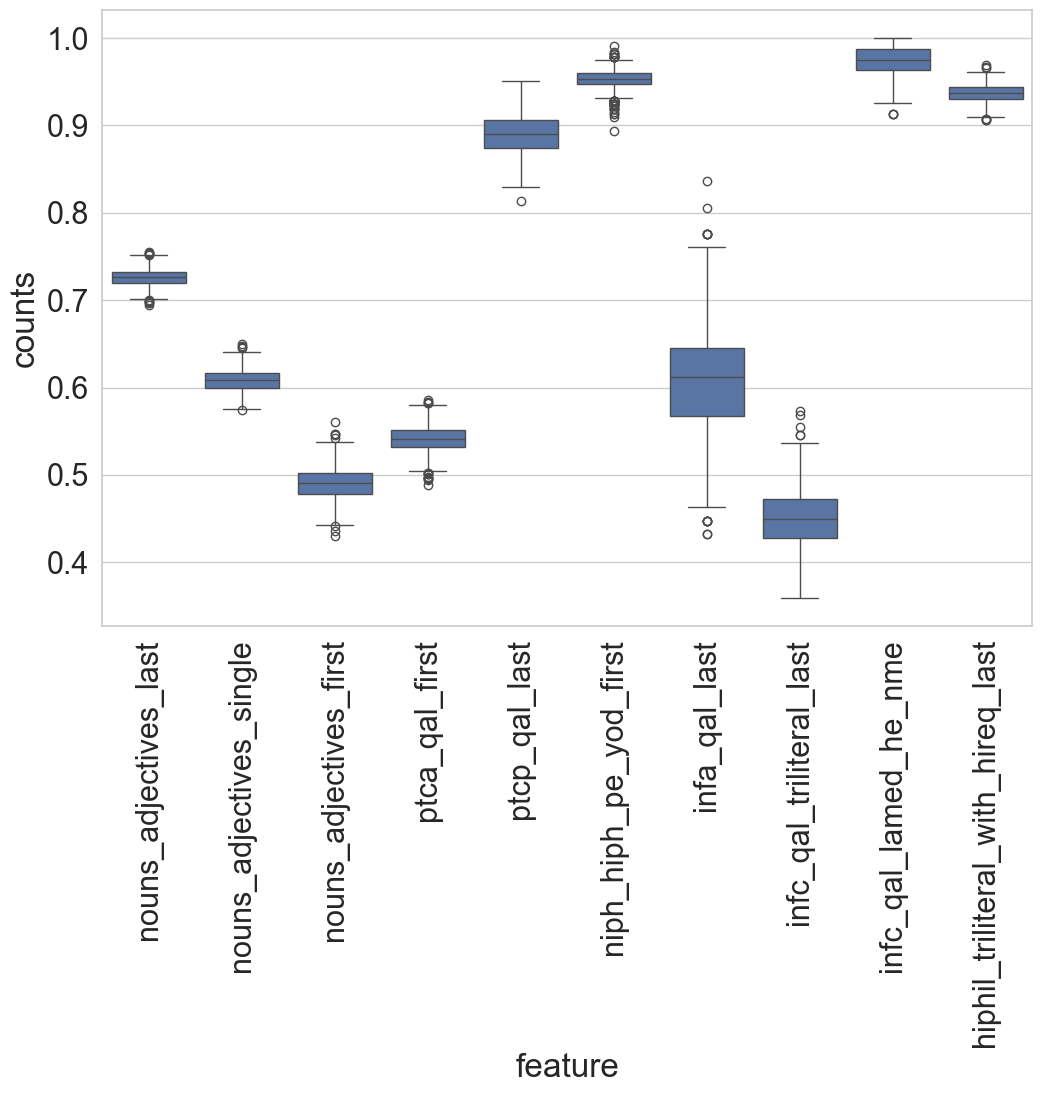

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid",
        font_scale=2,
        rc = {'figure.figsize':(12,8)})


g = sns.boxplot(x="feature", y="counts", data=feature_df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)



plt.savefig('fullness_features.png', bbox_inches='tight')



# Do the manuscripts

In [132]:
n_samples = 1000

manuscript_fullness_dict = {}

for man, count_dict in all_man_spelling.items():
    man_spellings = [0]* count_dict.get('defective', 0) + [1] * count_dict.get('full', 0)
    full_counts = sample_feature_fullness_spelling(man_spellings, n_samples)
    full_man_fractions = [count / len(man_spellings) for count in full_counts]
    manuscript_fullness_dict[man] = full_man_fractions

In [133]:
count_man_dfs = {}

for man, counts in manuscript_fullness_dict.items():
    df = pd.DataFrame(counts, columns=['counts'])
    df['manuscript'] = man
    count_man_dfs[man] = df
    
man_df = pd.concat(count_man_dfs)

C:\Users\geitb\AppData\Local\Temp\ipykernel_2820\3529675940.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


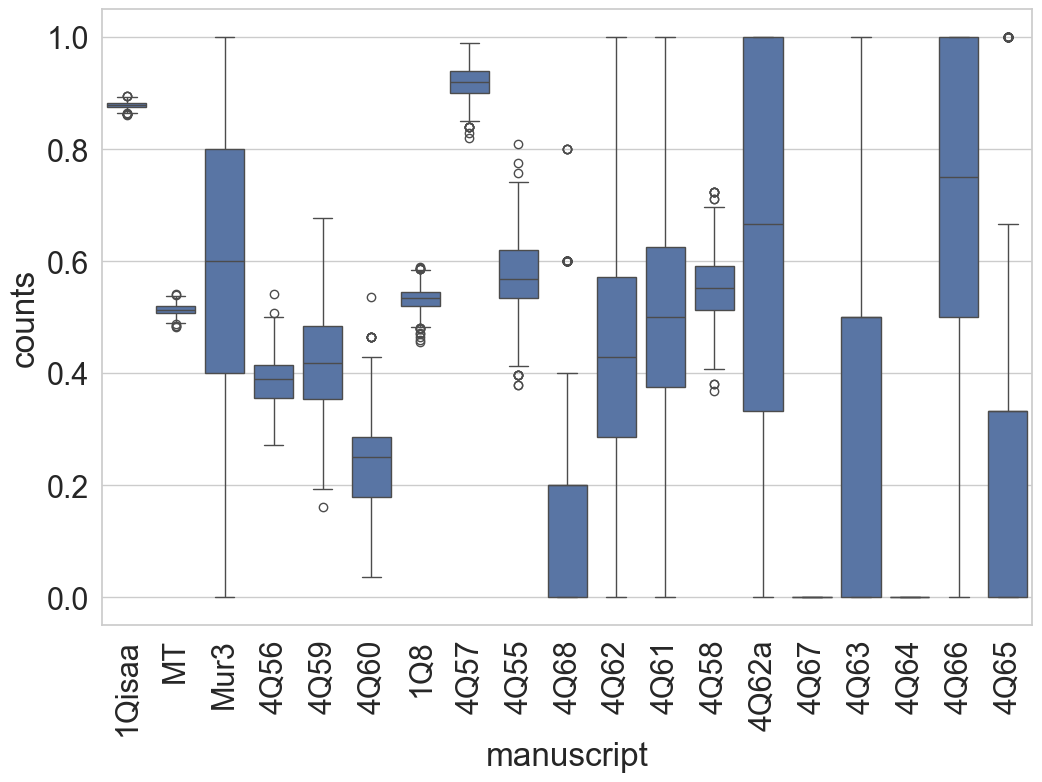

In [134]:
g = sns.boxplot(x="manuscript", y="counts", data=man_df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)


plt.savefig('fullness_manuscripts.png', bbox_inches='tight')

In [135]:
## All features per manuscript

In [136]:
feature_count_dict

defaultdict(<function __main__.<lambda>()>,
            {'nouns_adjectives_last': defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {'1Qisaa': defaultdict(int, {1: 778, 0: 94}),
                          'MT': defaultdict(int,
                                      {np.int64(1): 542, np.int64(0): 337}),
                          'Mur3': defaultdict(int, {np.int64(1): 1}),
                          '4Q56': defaultdict(int,
                                      {np.int64(0): 14, np.int64(1): 14}),
                          '4Q59': defaultdict(int,
                                      {np.int64(0): 4, np.int64(1): 5}),
                          '4Q60': defaultdict(int,
                                      {np.int64(0): 5, np.int64(1): 2}),
                          '1Q8': defaultdict(int,
                                      {np.int64(1): 105, np.int64(0): 82}),
                          '4Q57': defaultdict(int,
                                      

In [137]:
def calculate_fractions(man_count_dict, n_samples):
    man_feat_fullness_dict = {}

    for man, count_dict in man_count_dict.items():
        man_spellings = [0]* count_dict.get(0, 0) + [1] * count_dict.get(1, 0)
    
        full_counts = sample_feature_fullness_spelling(man_spellings, n_samples)
        full_man_fractions = [count / len(man_spellings) for count in full_counts]
        man_feat_fullness_dict[man] = full_man_fractions
    return man_feat_fullness_dict

In [196]:
n_samples = 1000

for feature, man_count_dict in feature_count_dict.items():
    man_feat_fullness_dict = calculate_fractions(man_count_dict, n_samples)
    man_df = make_feature_df(man_feat_fullness_dict)
    
    g = sns.boxplot(x="manuscript", y="counts", data=man_df)
    g.set_xticklabels(g.get_xticklabels(), rotation=90)

    plt.savefig(f'fullness_{feature}_manuscripts.png', bbox_inches='tight')
    plt.clf()

C:\Users\geitb\AppData\Local\Temp\ipykernel_2820\2156293304.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90)
C:\Users\geitb\AppData\Local\Temp\ipykernel_2820\2156293304.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90)
C:\Users\geitb\AppData\Local\Temp\ipykernel_2820\2156293304.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90)
C:\Users\geitb\AppData\Local\Temp\ipykernel_2820\2156293304.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90)
C:\Users

<Figure size 1200x800 with 0 Axes>

# ALL DATA OF ONE BOOK

In [167]:
BOOK = 'Isaiah'
IMAGE_FOLDER = './images_manuscr_comparisons'

In [168]:
def make_feature_df(man_feat_fullness_dict):
    count_man_dfs = {}

    for man, counts in man_feat_fullness_dict.items():
        df = pd.DataFrame(counts, columns=['counts'])
        df['manuscript'] = man
        count_man_dfs[man] = df
    
    man_df = pd.concat(count_man_dfs)
    return man_df

In [169]:
def make_image_folder_name(image_folder, book_name):
    return os.path.join(image_folder, book_name)
    

def make_image_folder(folder_name):
    
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

In [170]:
isa_df = dat[dat.book2 == BOOK]
isa_df['feature_type'] = isa_df['feature'] + '_' + isa_df['type']
isa_df.shape

C:\Users\geitb\AppData\Local\Temp\ipykernel_2820\3956005299.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isa_df['feature_type'] = isa_df['feature'] + '_' + isa_df['type']


(7146, 41)

In [171]:
image_folder_name = make_image_folder_name(IMAGE_FOLDER, BOOK)
make_image_folder(image_folder_name)

In [172]:
feat_man_count_dict_total = collections.defaultdict(lambda: collections.defaultdict(lambda: collections.defaultdict(int)))

for _, row in isa_df.iterrows():
    scroll = row.scroll
    ft = row.feature_type
    has_vl = row.has_vowel_letter
    feat_man_count_dict_total[ft][scroll][has_vl] += 1  

In [173]:
n_samples = 1000

for feature, man_count_dict in feat_man_count_dict_total.items():
    man_feat_fullness_dict = calculate_fractions(man_count_dict, n_samples)
    man_df = make_feature_df(man_feat_fullness_dict)
    
    g = sns.boxplot(x="manuscript", y="counts", data=man_df)
    g.set_xticklabels(g.get_xticklabels(), rotation=90)

    image_dir = os.path.join(image_folder_name, f'fullness_{feature}_{BOOK}_manuscripts_total.png')
    plt.savefig(image_dir, bbox_inches='tight')
    plt.clf()

C:\Users\geitb\AppData\Local\Temp\ipykernel_2820\3631697106.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90)
C:\Users\geitb\AppData\Local\Temp\ipykernel_2820\3631697106.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90)
C:\Users\geitb\AppData\Local\Temp\ipykernel_2820\3631697106.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90)
C:\Users\geitb\AppData\Local\Temp\ipykernel_2820\3631697106.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90)
C:\Users

<Figure size 1200x800 with 0 Axes>

In [174]:
feat_man_count_dict_total

defaultdict(<function __main__.<lambda>()>,
            {'nouns_adjectives_last': defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {'MT': defaultdict(int, {1: 570, 0: 360}),
                          '1Qisaa': defaultdict(int, {1: 819, 0: 111}),
                          '1Q8': defaultdict(int, {1: 107, 0: 86}),
                          '4Q55': defaultdict(int, {1: 9, 0: 9}),
                          '4Q56': defaultdict(int, {0: 14, 1: 14}),
                          '4Q57': defaultdict(int, {1: 35, 0: 3}),
                          '4Q58': defaultdict(int, {0: 11, 1: 10}),
                          '4Q59': defaultdict(int, {0: 4, 1: 5}),
                          '4Q60': defaultdict(int, {0: 5, 1: 2}),
                          '4Q61': defaultdict(int, {0: 3}),
                          '4Q62': defaultdict(int, {0: 1}),
                          '4Q62a': defaultdict(int, {1: 1}),
                          '4Q67': defaultdict(int, {0: 1}),
      

## Only features with all data

In [175]:
# Aggregate manuscripts

all_spelling = []
defective_feature_spelling = collections.defaultdict(int)
full_feature_spelling = collections.defaultdict(int)
feature_spelling_count = collections.defaultdict(int)

for feat, man_dict in feat_man_count_dict_total.items():
    for man, fullness_dict in man_dict.items():
        
        full_count = fullness_dict.get(1, 0)
        all_spelling += ([1] * full_count)
        
        defective_count = fullness_dict.get(0, 0)
        all_spelling += ([0] * defective_count)
        
        full_feature_spelling[feat] += full_count
        defective_feature_spelling[feat] += defective_count
        feature_spelling_count[feat] += full_count + defective_count

In [176]:
n_samples = 1000

feature_fullness_dict = {}

for feature, full_count in full_feature_spelling.items():
    def_count = defective_feature_spelling.get(feature, 0)
    feature_spellings = [0]* def_count + [1] * full_count
    full_counts = sample_feature_fullness_spelling(feature_spellings, n_samples)
    full_feature_fractions = [count / len(feature_spellings) for count in full_counts]
    feature_fullness_dict[feature] = full_feature_fractions

In [177]:
feature_df = make_feature_df(feature_fullness_dict)

In [178]:
feature_df.head()

counts             manuscript
nouns_adjectives_last 0  0.714940  nouns_adjectives_last
                      1  0.728689  nouns_adjectives_last
                      2  0.713566  nouns_adjectives_last
                      3  0.717690  nouns_adjectives_last
                      4  0.731439  nouns_adjectives_last

C:\Users\geitb\AppData\Local\Temp\ipykernel_2820\669107247.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


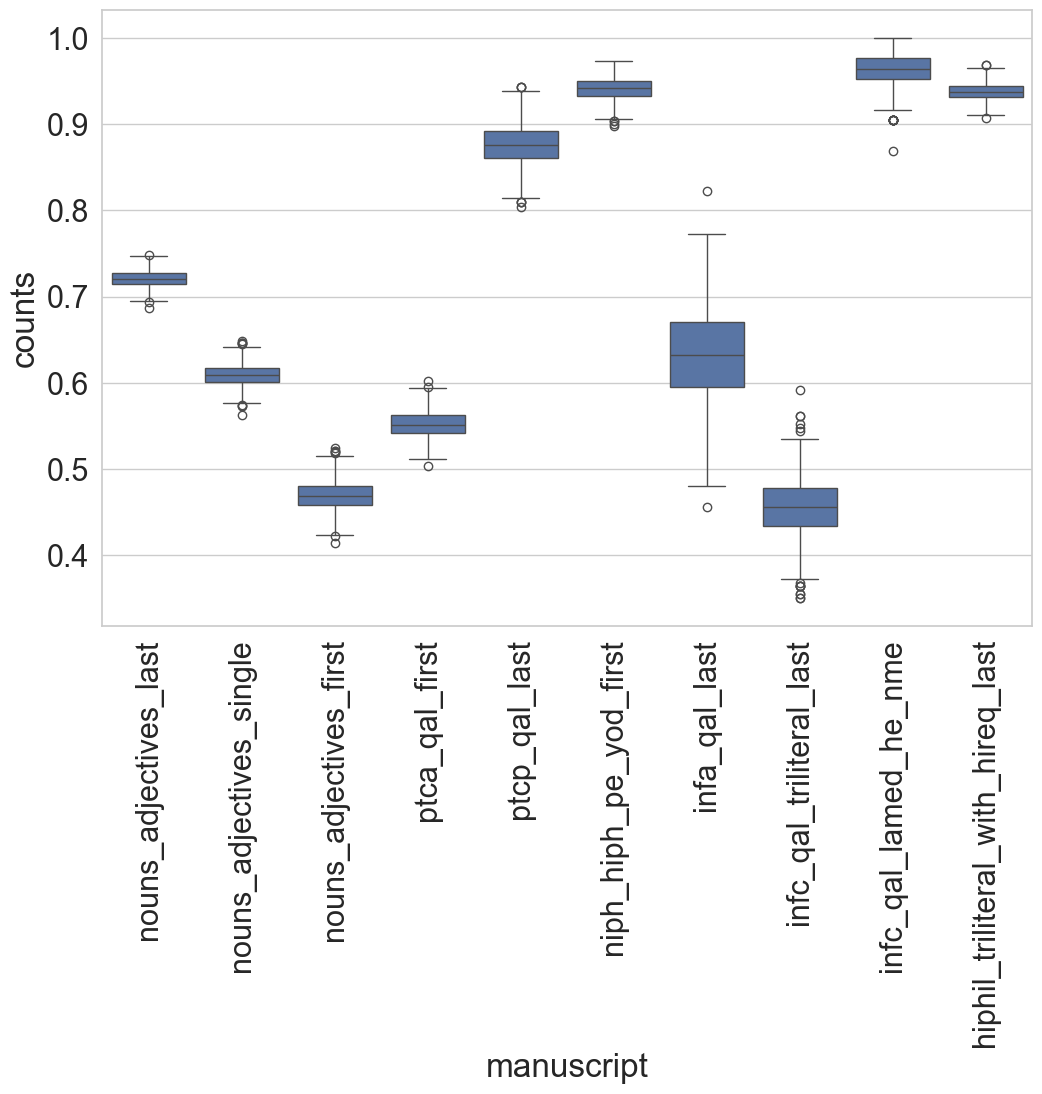

In [179]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid",
        font_scale=2,
        rc = {'figure.figsize':(12,8)})

g = sns.boxplot(x='manuscript', y='counts', data=feature_df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

image_dir = os.path.join(image_folder_name, f'fullness_features_{BOOK}_total.png')
plt.savefig(image_dir, bbox_inches='tight')

## Only manuscripts with all data

In [180]:
# Aggregate features

all_man_spelling = collections.defaultdict(lambda: collections.defaultdict(int))

for feat, man_dict in feat_man_count_dict_total.items():
    for man, fullness_dict in man_dict.items():
        
        full_count = fullness_dict.get(1, 0)
        all_man_spelling[man]['full'] += full_count
        
        defective_count = fullness_dict.get(0, 0)
        all_man_spelling[man]['defective'] += defective_count

In [181]:
n_samples = 1000

manuscript_fullness_dict = {}

for man, count_dict in all_man_spelling.items():
    man_spellings = [0]* count_dict.get('defective', 0) + [1] * count_dict.get('full', 0)
    full_counts = sample_feature_fullness_spelling(man_spellings, n_samples)
    full_man_fractions = [count / len(man_spellings) for count in full_counts]
    manuscript_fullness_dict[man] = full_man_fractions

In [182]:
man_df = make_feature_df(manuscript_fullness_dict)

C:\Users\geitb\AppData\Local\Temp\ipykernel_2820\2737527783.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


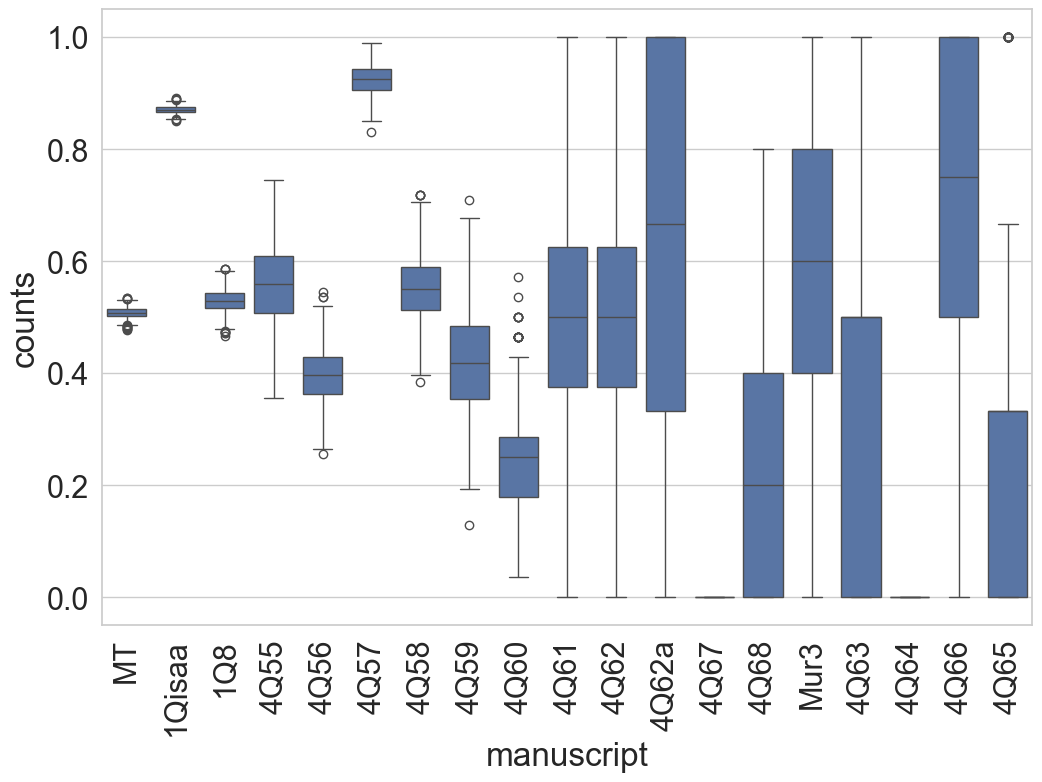

In [183]:
g = sns.boxplot(x="manuscript", y="counts", data=man_df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

image_dir = os.path.join(image_folder_name, f'fullness_manuscripts_{BOOK}_total.png')
plt.savefig(image_dir, bbox_inches='tight')

In [184]:
# GET PARALLELS OF WORDS IN SPECIFIC MANUSCRPT

In [185]:
scroll = '4Q58'
feature = 'ptca_qal_first'

isa_feat_scroll = isa_df[(isa_df.feature_type == feature) & (isa_df.scroll == scroll)]
nodes = isa_feat_scroll.tf_id

In [186]:
def get_node_info_from_df(node, df):
    row = isa_df[isa_df.tf_id == node]
    lex = row.lex.iloc[0]
    g_cons = row.g_cons.iloc[0]
    has_vl = row.has_vowel_letter.iloc[0]
    return lex, g_cons, has_vl

In [187]:
n = 0
unequal_with_mt = 0

count_dict = collections.defaultdict(lambda: collections.defaultdict(int))

for node in nodes:
    #print(hif_match_dict[(node, scroll)])
    
    row = isa_df[isa_df.tf_id == node]
    bo, ch, ve = row.book.iloc[0], row.chapter.iloc[0], row.verse.iloc[0]
    lex, g_cons, has_vl = get_node_info_from_df(node, isa_df)
    print(scroll, ch, ve, lex, g_cons, has_vl)
    n += 1
    corr_nodes = hif_match_dict[(node, scroll)]
    count_dict[scroll][has_vl] += 1
  
    for corr_scr, node in corr_nodes.items():
        corr_lex, corr_g_cons, corr_has_vl = get_node_info_from_df(node, isa_df)
        count_dict[corr_scr][corr_has_vl] += 1
        
        print(corr_scr, corr_lex, corr_g_cons, corr_has_vl)
        
        if corr_scr == 'MT' and has_vl != corr_has_vl:
            unequal_with_mt += 1
        
    print()
    
print(n, unequal_with_mt)

4Q58 45 20 NF>[ NF>JM 0
MT NF>[ NF>JM 0
1Qisaa NF>[ NWF>JM 1

4Q58 46 10 >MR[ >MR 0
MT >MR[ >MR 0
1Q8 >MR[ >MR 0
1Qisaa >MR[ >MR 0

4Q58 47 8 JCB[ JCBT 0
MT JCB[ JWCBT 1
1Qisaa JCB[ JWCBT 1

4Q58 48 13 QR>[ QR> 0
MT QR>[ QR> 0
1Qisaa QR>[ QWRH 1

4Q58 52 7 >MR[ >MR 0
MT >MR[ >MR 0
1Qisaa >MR[ >WMR 1

4Q58 53 12 PC<[ PC<JM 0
MT PC<[ PC<JM 0
1Qisaa PC<[ PWC<JM 1

4Q58 57 13 XSH[ XSH 0
MT XSH[ XWSH 1
1Qisaa XSH[ XWSH 1

4Q58 57 19 BR>[ BWRH 1
MT BR>[ BWR> 1
1Qisaa BR>[ BWRH 1

8 2


In [188]:
count_dict['1Q8'][1]

0

In [189]:
count_dict['MT'][1]

3

In [190]:
q8 = dat[dat.scroll == '1Q8']

In [191]:
q8.shape

(591, 40)

In [192]:
q8_first = q8[q8.chapter < 34]
q8_second = q8[q8.chapter >= 34]

In [193]:
sum(q8_first.has_vowel_letter)/q8_first.shape[0]

0.6470588235294118

In [194]:
sum(q8_second.has_vowel_letter)/q8_second.shape[0]

0.5185185185185185